<a href="https://colab.research.google.com/github/markusmaresch/image_classification/blob/main/Document_Extraction_deeplabv3_mbv3_%5Btraining_%2B_inference%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Pi

In [ ]:
!nvidia-smi

Thu Sep  5 11:08:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Document Segmentation Using Deep Learning in PyTorch [Training]


In [ ]:
!pip install -qU livelossplot
!pip install -qU torchmetrics

# dataset download
!wget -O document_dataset_resized.zip https://www.dropbox.com/s/rk37cuwtav5j1s7/document_dataset_resized.zip?dl=1
!unzip -qq './document_dataset_resized.zip'
# download the trained model checkpoints and test dataset
!wget -O model_mbv3_iou_mix_2C049.pth https://www.dropbox.com/s/4znmfi5ew1u5z9y/model_mbv3_iou_mix_2C049.pth?dl=1
!wget -O doc_scan.zip "https://www.dropbox.com/scl/fo/w3i08lmjnd6ba3td89a3p/h?dl=1&rlkey=unuq45366j21xctj9ovt9ehd3"
!unzip -qq /content/doc_scan.zip -d ./doc_scan
!rm /content/doc_scan.zip
!rm /content/document_dataset_resized.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 14.4 MB/s eta 0:00:00
--2024-10-03 16:53:18--  https://www.dropbox.com/s/rk37cuwtav5j1s7/document_dataset_resized.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/7uyy5zvkusq65ot172yuw/document_dataset_resized.zip?rlkey=rytxsekvdkgxmsnyjg0azosme&dl=1 [following]
--2024-10-03 16:53:19--  https://www.dropbox.com/scl/fi/7uyy5zvkusq65ot172yuw/document_dataset_resized.zip?rlkey=rytxsekvdkgxmsnyjg0azosme&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc32c771013b4f85d49847889a2e.dl.dropboxusercontent.com/cd/0/inline/Cbxl_aqHNnvQCwjGm7gT0RawNwGIhS2Kx5D0E2zE3pT2RXcZU3--mgKSK_LWuNkc7PsUjZGi-ke6ROKXUFGJcUDKjS2Mfqx6TDhKT3I3vJLZSerqNkGPQkaRQR3KvBpQ

In [ ]:
import os
import gc
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision.models as models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import albumentations as A
import PIL

from torchvision.utils import make_grid, save_image
from torchmetrics import MeanMetric
from livelossplot import PlotLosses
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_resnet101

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


# For reproducibility
seed = 42
seed_everything(seed)

In [ ]:
DATA_DIR = "./document_dataset_resized"

BESTMODEL_PATH = "model_mbv3_iou_mix_2C_aux.pth"  # path to save model weights

IMAGE_SIZE = 384
NUM_WORKERS = 2

# Dataset Preparation

In [ ]:
import torchvision.transforms as torchvision_T

def train_transforms(mean=(0.4611, 0.4359, 0.3905),
                      std=(0.2193, 0.2150, 0.2109)
):
    transforms = torchvision_T.Compose([
        torchvision_T.ToTensor(),
        torchvision_T.RandomGrayscale(p=0.4),
        torchvision_T.Normalize(mean, std),
    ])

    return transforms


def common_transforms(mean=(0.4611, 0.4359, 0.3905),
                       std=(0.2193, 0.2150, 0.2109)
):
    transforms = torchvision_T.Compose([
        torchvision_T.ToTensor(),
        torchvision_T.Normalize(mean, std),
    ])

    return transforms


class SegDataset(Dataset):
    def __init__(self, *,
                 img_paths,
                 mask_paths,
                 image_size=(384, 384),
                 data_type="train"
    ):
        self.data_type  = data_type
        self.img_paths  = img_paths
        self.mask_paths = mask_paths
        self.image_size = image_size


        if self.data_type == "train":
            self.transforms = train_transforms()
        else:
            self.transforms = common_transforms()

    def read_file(self, path):
        file = cv2.imread(path)[:, :, ::-1]
        file = cv2.resize( file,
                           self.image_size,
                           interpolation=cv2.INTER_NEAREST
                        )
        return file

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):

        image_path = self.img_paths[index]
        image = self.read_file(image_path)
        image = self.transforms(image)

        mask_path = self.mask_paths[index]

        gt_mask = self.read_file(mask_path).astype(np.int32)

        _mask = np.zeros((*self.image_size, 2), dtype=np.float32)

	   # BACKGROUND
        _mask[:, :, 0] = np.where(gt_mask[:, :, 0] == 0,   1.0, 0.0)
	   # DOCUMENT
        _mask[:, :, 1] = np.where(gt_mask[:, :, 0] == 255, 1.0, 0.0)

        mask = torch.from_numpy(_mask).permute(2, 0, 1)

        return image, mask


In [ ]:
def get_dataset(data_directory, batch_size=16):

    train_img_dir = os.path.join(data_directory, "train", "images")
    train_msk_dir = os.path.join(data_directory, "train", "masks")

    valid_img_dir = os.path.join(data_directory, "valid", "images")
    valid_msk_dir = os.path.join(data_directory, "valid", "masks")


    train_img_paths = [os.path.join(train_img_dir, i) for i in os.listdir(train_img_dir)]
    train_msk_paths = [os.path.join(train_msk_dir, i) for i in os.listdir(train_msk_dir)]

    valid_img_paths = [os.path.join(valid_img_dir, i) for i in os.listdir(valid_img_dir)]
    valid_msk_paths = [os.path.join(valid_msk_dir, i) for i in os.listdir(valid_msk_dir)]

    train_ds = SegDataset(img_paths=train_img_paths, mask_paths=train_msk_paths, data_type="train")
    valid_ds = SegDataset(img_paths=valid_img_paths, mask_paths=valid_msk_paths, data_type="valid")

    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=NUM_WORKERS, shuffle=True,  pin_memory=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)

    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = get_dataset(DATA_DIR, batch_size=1)

In [ ]:
for i, j in valid_loader:
    print(i.shape, j.shape, j.dtype)
    break

torch.Size([1, 3, 384, 384]) torch.Size([1, 2, 384, 384]) torch.float32


In [ ]:
def denormalize(tensors, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Normalization parameters for pre-trained PyTorch models
     Denormalizes image tensors using mean and std """

    for c in range(3):
        tensors[:,c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0., max=1.)

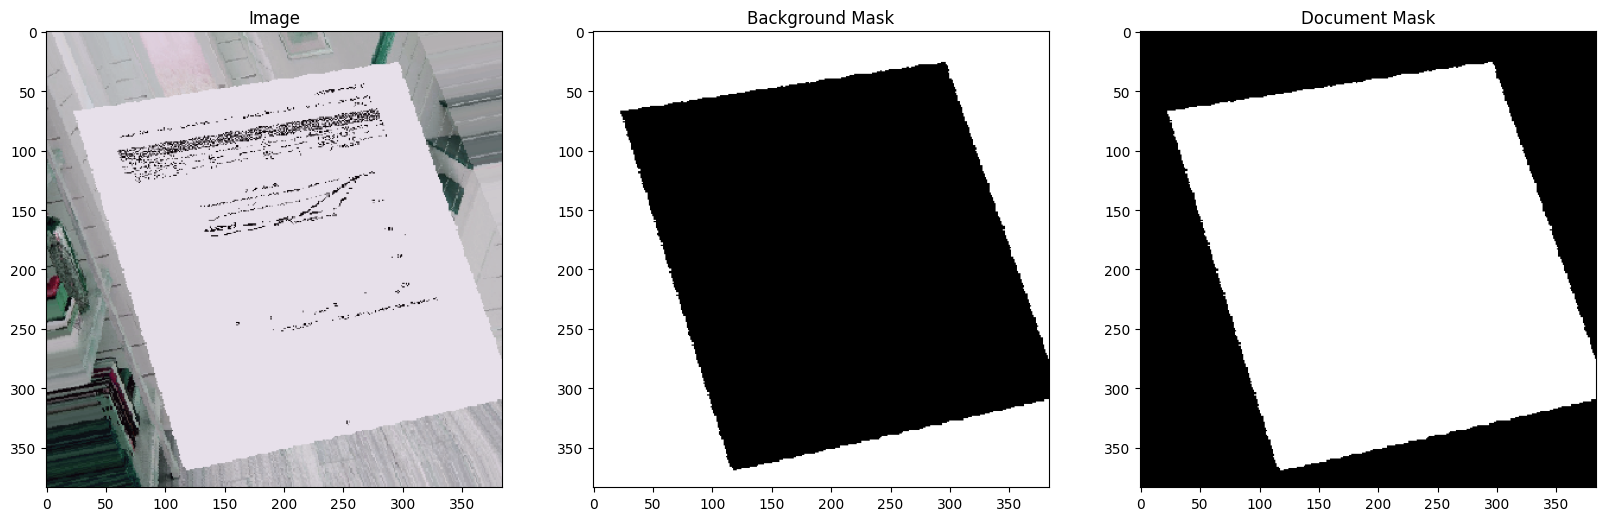

In [ ]:
for image, mask in valid_loader:
    image = denormalize(image)
    image = image[0]

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    x = image.permute(1, 2, 0).numpy()
    plt.imshow(x)
    plt.title('Image')

    labels = mask[0]

    plt.subplot(1, 3, 2)
    plt.imshow(labels[0].numpy(), cmap='gray')
    plt.title("Background Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(labels[1].numpy(), cmap='gray')
    plt.title("Document Mask")

    plt.show()
    plt.close()

    break

# Create Model

In [ ]:


def prepare_model(backbone_model="mbv3", num_classes=2):

    # Initialize model with pre-trained weights.
    weights = 'DEFAULT'
    if backbone_model == "mbv3":
        model = deeplabv3_mobilenet_v3_large(weights=weights)
    elif backbone_model == "r50":
        model = deeplabv3_resnet50(weights=weights)
    elif backbone_model == "r101":
        model = deeplabv3_resnet101(weights=weights)
    else:
        raise ValueError("Wrong backbone model passed. Must be one of 'mbv3', 'r50' and 'r101' ")

    # Update the number of output channels for the output layer.
    # This will remove the pre-trained weights for the last layer.
    model.classifier[4]     = nn.LazyConv2d(num_classes, 1)
    model.aux_classifier[4] = nn.LazyConv2d(num_classes, 1)
    return model

In [ ]:
# Testing

model = prepare_model(num_classes=2)

model.train()
out = model(torch.randn((2, 3, 384, 384)))
out['out'].shape

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:02<00:00, 17.8MB/s]


torch.Size([2, 2, 384, 384])

# Loss and Metric Class

In [ ]:
def intermediate_metric_calculation(
    predictions, targets, use_dice=False, smooth=1e-6, dims=(2, 3)
):
    # dimscorresponding to image height and width: [B, C, H, W].

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = (predictions * targets).sum(dim=dims) + smooth

    # Summation: |G| + |P|. Shape: (batch_size, num_classes).
    summation = (predictions.sum(dim=dims) + targets.sum(dim=dims)) + smooth

    if use_dice:
        # Dice Shape: (batch_size, num_classes)
        metric = (2.0 * intersection) / summation
    else:
        # Union. Shape: (batch_size, num_classes)
        union = summation - intersection

        # IoU Shape: (batch_size, num_classes)
        metric = intersection /  union

    # Compute the mean over the remaining axes (batch and classes).
    # Shape: Scalar
    total = metric.mean()

    return total

In [ ]:
class Loss(nn.Module):
    def __init__(self, smooth=1e-6, use_dice=False):
        super().__init__()
        self.smooth = smooth
        self.use_dice = use_dice


    def forward(self, predictions, targets):
        # predictions --> (B, #C, H, W) unnormalized
        # targets     --> (B, #C, H, W) one-hot encoded

        # Normalize model predictions
        predictions = torch.sigmoid(predictions)

        # Calculate pixel-wise loss for both channels. Shape: Scalar
        pixel_loss = F.binary_cross_entropy(predictions, targets, reduction="mean")

        mask_loss  = 1 - intermediate_metric_calculation(predictions, targets, use_dice=self.use_dice, smooth=self.smooth)
        total_loss = mask_loss + pixel_loss

        return total_loss

In [ ]:
def convert_2_onehot(matrix, num_classes=3):
    '''
    Perform one-hot encoding across the channel dimension.
    '''
    matrix = matrix.permute(0, 2, 3, 1)
    matrix = torch.argmax(matrix, dim=-1)
    matrix = torch.nn.functional.one_hot(matrix, num_classes=num_classes)
    matrix = matrix.permute(0, 3, 1, 2)

    return matrix

class Metric(nn.Module):
    def __init__(self, num_classes=3, smooth=1e-6, use_dice=False):
        super().__init__()
        self.num_classes = num_classes
        self.smooth      = smooth
        self.use_dice    = use_dice

    def forward(self, predictions, targets):
        # predictions  --> (B, #C, H, W) unnormalized
        # targets      --> (B, #C, H, W) one-hot encoded

        # Converting unnormalized predictions into one-hot encoded across channels.
        # Shape: (B, #C, H, W)
        predictions = convert_2_onehot(predictions, num_classes=self.num_classes) # one hot encoded

        metric = intermediate_metric_calculation(predictions, targets, use_dice=self.use_dice, smooth=self.smooth)

        # Compute the mean over the remaining axes (batch and classes). Shape: Scalar
        return metric

# Training Helper Functions

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_default_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def step(model, epoch_num=None, loader=None, optimizer_fn=None, loss_fn=None, metric_fn=None, is_train=False, metric_name="iou"):

    loss_record   = MeanMetric()
    metric_record = MeanMetric()

    loader_len = len(loader)

    text = "Train" if is_train else "Valid"

    for data in tqdm(iterable=loader, total=loader_len, dynamic_ncols=True, desc=f"{text} :: Epoch: {epoch_num}"):

        if is_train:
            preds = model(data[0])["out"]
        else:
            with torch.no_grad():
                preds = model(data[0])["out"].detach()

        loss = loss_fn(preds, data[1])

        if is_train:
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()

        metric = metric_fn(preds.detach(), data[1])

        loss_value = loss.detach().item()
        metric_value = metric.detach().item()

        loss_record.update(loss_value)
        metric_record.update(metric_value)

    current_loss   = loss_record.compute()
    current_metric = metric_record.compute()

    # print(f"\rEpoch {epoch:>03} :: TRAIN :: LOSS: {loss_record.compute()}, {metric_name.upper()}: {metric_record.compute()}\t\t\t\t", end="")

    return current_loss, current_metric

# Training

It takes almost 3 minutes to train for a single epoch and for validation almost a minute, for the training the model for 50 epoch it will take approximately (3+1) *50 = 200 m = 3.33 h. So, we will only be showing the training for 2 epochs and for inference load the previously trained model.

In [ ]:
NUM_EPOCHS = 2 #50
BATCH_SIZE = 64
NUM_CLASSES = 2

device = get_default_device()

backbone_model_name = "mbv3" # mbv3 | r50 | r101

model = prepare_model(backbone_model=backbone_model_name, num_classes=NUM_CLASSES)
model.to(device)

# Dummy pass through the model
_ = model(torch.randn((2, 3, 384, 384), device=device))


train_loader, valid_loader = get_dataset(data_directory=DATA_DIR, batch_size=BATCH_SIZE)
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

metric_name = "iou"
use_dice = True if metric_name == "dice" else False

metric_fn = Metric(num_classes=NUM_CLASSES, use_dice=use_dice).to(device)
loss_fn   = Loss(use_dice=use_dice).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

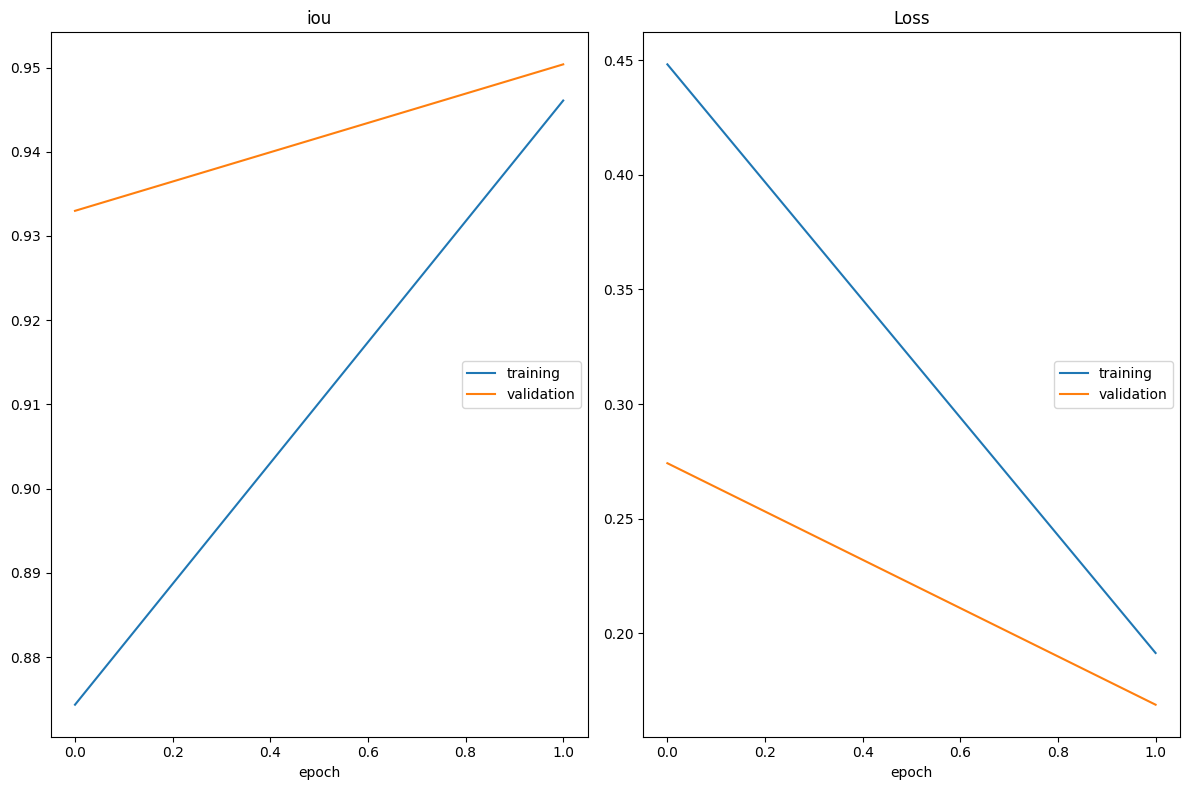

iou
	training         	 (min:    0.874, max:    0.946, cur:    0.946)
	validation       	 (min:    0.933, max:    0.950, cur:    0.950)
Loss
	training         	 (min:    0.191, max:    0.448, cur:    0.191)
	validation       	 (min:    0.169, max:    0.274, cur:    0.169)

Saving model.....


In [ ]:
liveloss = PlotLosses()

best_metric = 0.0

for epoch in range(1, NUM_EPOCHS + 1):

    logs = {}

    model.train()
    train_loss, train_metric = step(model,
                                    epoch_num=epoch,
                                    loader=train_loader,
                                    optimizer_fn=optimizer,
                                    loss_fn=loss_fn,
                                    metric_fn=metric_fn,
                                    is_train=True,
                                    metric_name=metric_name,
                                    )

    model.eval()
    valid_loss, valid_metric = step(model,
                                    epoch_num=epoch,
                                    loader=valid_loader,
                                    loss_fn=loss_fn,
                                    metric_fn=metric_fn,
                                    is_train=False,
                                    metric_name=metric_name,
                                    )

    logs['loss']               = train_loss
    logs[metric_name]          = train_metric
    logs['val_loss']           = valid_loss
    logs[f'val_{metric_name}'] = valid_metric

    liveloss.update(logs)
    liveloss.send()

    if valid_metric >= best_metric:
        print("\nSaving model.....")
        torch.save(model.state_dict(), BESTMODEL_PATH)
        best_metric = valid_metric

# Inference and Visualization:

Let's load the trained model and perform inference in some unseen dataset.

The `order_points` function rearranges a set of four 2D points to consistently represent the top-left, top-right, bottom-right, and bottom-left corners. The `find_dest` function calculates the destination points of a perspective transform by determining the maximum width and height based on the provided four corner points.

In [ ]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    pts = np.array(pts)
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect.astype("int").tolist()


def find_dest(pts):
    (tl, tr, br, bl) = pts
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
    return order_points(destination_corners)

The `image_preproces_transforms` function creates a set of image preprocessing transformations that convert an image to a tensor and normalize it using specified mean and standard deviation values. The `load_model` function loads a pre-trained DeepLabV3 model (either MobileNetV3 or ResNet50 based) with a specified number of classes, loads the model's weights from a checkpoint, moves it to the specified device, and runs a dummy input through the model to ensure it's in evaluation mode.

In [ ]:
def image_preproces_transforms(
    mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)
):
    common_transforms = torchvision_T.Compose(
        [torchvision_T.ToTensor(), torchvision_T.Normalize(mean, std),]
    )

    return common_transforms


def load_model(num_classes=1, model_name="mbv3", checkpoint_path=None, device=None):

    if model_name == "mbv3":
        model = deeplabv3_mobilenet_v3_large(num_classes=num_classes)

    else:
        model = deeplabv3_resnet50(num_classes=num_classes)

    model.to(device)
    checkpoints = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoints, strict=False)
    model.eval()

    _ = model(torch.randn((2, 3, 384, 384)).to(device))

    return model

In [ ]:
# lets load the model
CHECKPOINT_MODEL_PATH = "./model_mbv3_iou_mix_2C049.pth"

trained_model = load_model(num_classes=2, model_name="mbv3", checkpoint_path=CHECKPOINT_MODEL_PATH, device=device)
preprocess_transforms = image_preproces_transforms()

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 152MB/s]
<ipython-input-21-94859639e8ad>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full 

The `extract` function takes an input image and a trained model, resizes the image, processes it through the model, and performs edge detection to find the document's contour. If the detected document's corners are outside the image boundaries, the function pads the image, adjusts the corners, and applies a perspective transform to extract the document with correct alignment.

In [ ]:
def extract(image_true=None, trained_model=None, image_size=384, BUFFER=10):
    global preprocess_transforms

    IMAGE_SIZE = image_size
    half = IMAGE_SIZE // 2

    imH, imW, C = image_true.shape

    img = cv2.resize(image_true, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

    scale_x = imW / IMAGE_SIZE
    scale_y = imH / IMAGE_SIZE

    img = preprocess_transforms(img)
    img = torch.unsqueeze(img, dim=0).to(device)

    with torch.no_grad():
        out = trained_model(img)["out"].cpu()

    del img
    gc.collect()

    out = torch.argmax(out, dim=1, keepdims=True).permute(0, 2, 3, 1)[0].numpy().squeeze().astype(np.int32)
    r_H, r_W = out.shape

    _out_extended = np.zeros((IMAGE_SIZE + r_H, IMAGE_SIZE + r_W), dtype=out.dtype)
    _out_extended[half : half + IMAGE_SIZE, half : half + IMAGE_SIZE] = out * 255
    out = _out_extended.copy()

    del _out_extended
    gc.collect()

    # Edge Detection.
    canny = cv2.Canny(out.astype(np.uint8), 225, 255)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    contours, _ = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    page = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    # ==========================================
    epsilon = 0.02 * cv2.arcLength(page, True)
    corners = cv2.approxPolyDP(page, epsilon, True)

    corners = np.concatenate(corners).astype(np.float32)

    corners[:, 0] -= half
    corners[:, 1] -= half

    corners[:, 0] *= scale_x
    corners[:, 1] *= scale_y

    # check if corners are inside.
    # if not find smallest enclosing box, expand_image then extract document
    # else extract document

    if not (np.all(corners.min(axis=0) >= (0, 0)) and np.all(corners.max(axis=0) <= (imW, imH))):

        left_pad, top_pad, right_pad, bottom_pad = 0, 0, 0, 0

        rect = cv2.minAreaRect(corners.reshape((-1, 1, 2)))
        box = cv2.boxPoints(rect)
        box_corners = np.int32(box)
        #     box_corners = minimum_bounding_rectangle(corners)

        box_x_min = np.min(box_corners[:, 0])
        box_x_max = np.max(box_corners[:, 0])
        box_y_min = np.min(box_corners[:, 1])
        box_y_max = np.max(box_corners[:, 1])

        # Find corner point which doesn't satify the image constraint
        # and record the amount of shift required to make the box
        # corner satisfy the constraint
        if box_x_min <= 0:
            left_pad = abs(box_x_min) + BUFFER

        if box_x_max >= imW:
            right_pad = (box_x_max - imW) + BUFFER

        if box_y_min <= 0:
            top_pad = abs(box_y_min) + BUFFER

        if box_y_max >= imH:
            bottom_pad = (box_y_max - imH) + BUFFER

        # new image with additional zeros pixels
        image_extended = np.zeros((top_pad + bottom_pad + imH, left_pad + right_pad + imW, C), dtype=image_true.dtype)

        # adjust original image within the new 'image_extended'
        image_extended[top_pad : top_pad + imH, left_pad : left_pad + imW, :] = image_true
        image_extended = image_extended.astype(np.float32)

        # shifting 'box_corners' the required amount
        box_corners[:, 0] += left_pad
        box_corners[:, 1] += top_pad

        corners = box_corners
        image_true = image_extended

    corners = sorted(corners.tolist())
    corners = order_points(corners)
    destination_corners = find_dest(corners)
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))

    final = cv2.warpPerspective(image_true, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LANCZOS4)
    final = np.clip(final, a_min=0., a_max=255.)

    return final

The code iterates through each image file in the `DATA_DIR`, reads the image, and uses the `extract` function to detect and extract the document within the image using a trained model. It then displays both the original image and the extracted document side by side using `matplotlib`.

IMG-5898.jpg


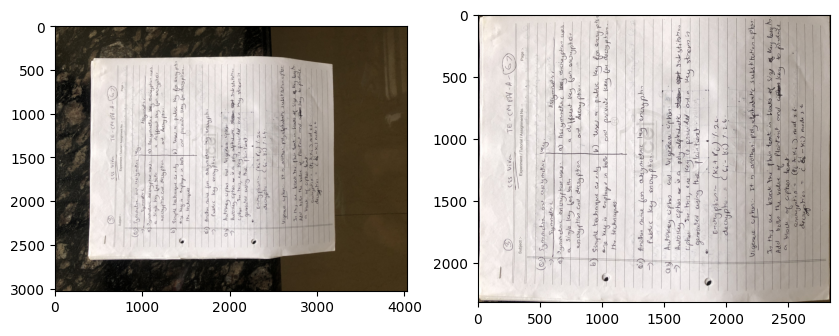

IMG-5897.jpg


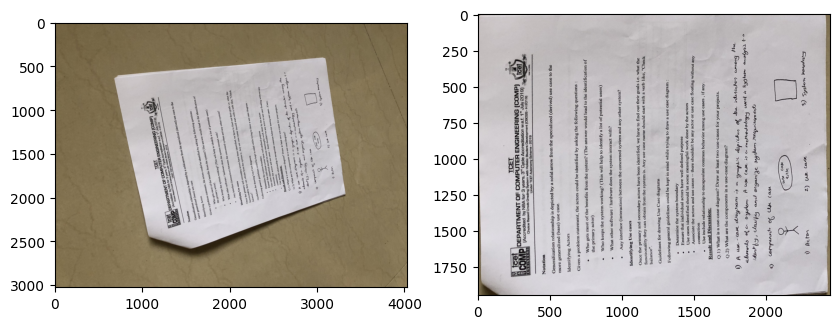

IMG_20220721_162757.jpg


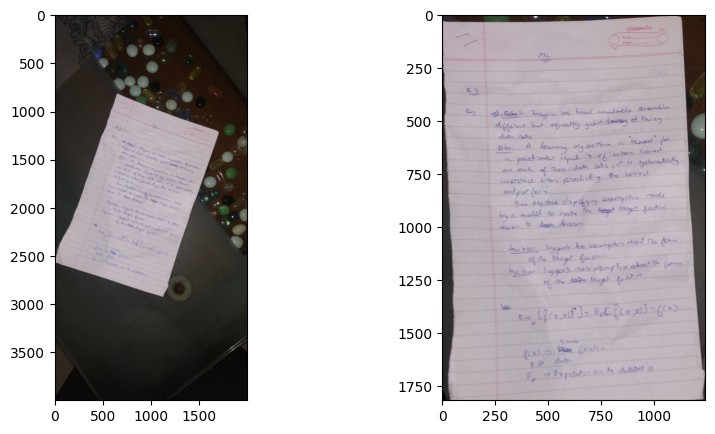

IMG_20220721_162811.jpg


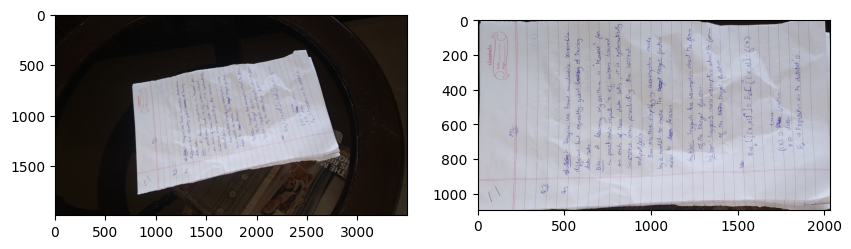

corner-outside-frame.jpg


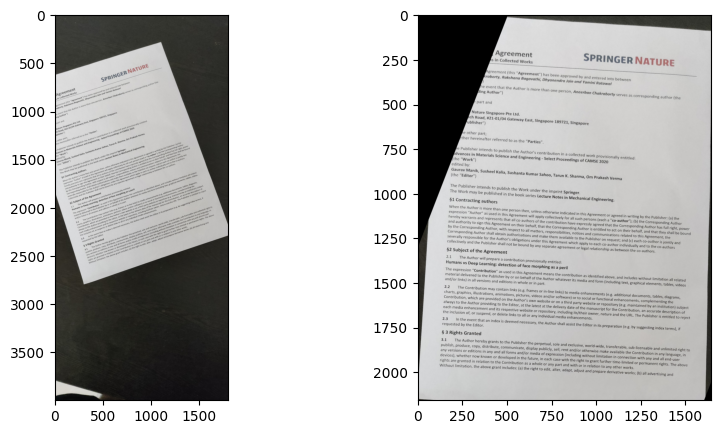

IMG-5896.jpg


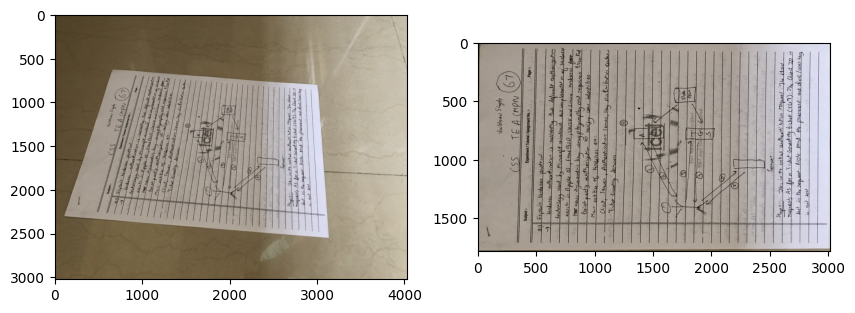

In [ ]:
DATA_DIR = "/content/doc_scan/test_images"

for idx, image_name in enumerate(os.listdir(DATA_DIR)):
    print(image_name)

    image_path = os.path.join(DATA_DIR, image_name)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)[:, :, ::-1]

    document = extract(image_true=image, trained_model=trained_model)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(document / 255.0)
    plt.show()
    plt.close()